<a href="https://colab.research.google.com/github/saad484/Mathematical_foundations_for_ML/blob/main/Copie_de_Programming_Session_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Mathematical Foundations for ML </center>

## <center>Programming Session 2 - Unsupervised Learning and Clustering Techniques
</center>

# Generating Synthetic Data

### Setup and synthetic data generation functions

This section demonstrates how to generate synthetic datasets with both
linearly correlated features and non-linearly related features, and how
to visualize the relationships between features.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
import warnings
import time
from scipy.stats import spearmanr

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
def generate_correlated_dataset(n_samples=1000, n_clusters=3, features_per_cluster=5,
                              n_noise=5, correlation=0.8, random_state=42):
    """
    Generate a dataset where features within each cluster have high linear correlation.

    Parameters:
    -----------
    n_samples : int
        Number of samples (rows) in the dataset
    n_clusters : int
        Number of feature clusters to generate
    features_per_cluster : int
        Number of features in each cluster (including one base feature)
    n_noise : int
        Number of random noise features to add (uncorrelated with other features)
    correlation : float
        Base correlation coefficient between features in the same cluster (0-1)
    random_state : int
        Seed for random number generation to ensure reproducibility

    Returns:
    --------
    X : pandas DataFrame
        Feature matrix with standardized features
    y : pandas Series
        Binary target variable generated from base features
    cluster_membership : dict
        Dictionary mapping feature names to their cluster names
    true_importance : dict
        Dictionary containing true feature and cluster importance values
    """
    np.random.seed(random_state)

    # Calculate total number of features
    n_features = n_clusters * features_per_cluster + n_noise

    print(f"Generating linearly correlated dataset with:")
    print(f"- {n_samples} samples")
    print(f"- {n_clusters} clusters with {features_per_cluster} features each")
    print(f"- {n_noise} noise features")
    print(f"- Base correlation: {correlation}")

    # Initialize empty dataframe to hold our features
    X = pd.DataFrame()

    # Dictionary to track which cluster each feature belongs to
    cluster_membership = {}

    # Generate one base feature per cluster
    for i in range(n_clusters):
        # Create a base feature name and generate random normal values
        base_feature_name = f"Base_{i}"
        X[base_feature_name] = np.random.normal(0, 1, n_samples)
        cluster_membership[base_feature_name] = f"Cluster_{i}"

        # Generate correlated features for this cluster
        for j in range(1, features_per_cluster):
            feature_name = f"Corr_{i}_{j}"

            # Create correlated feature using the formula:
            # new_feature = correlation * base_feature + noise * sqrt(1-correlation²)
            # This ensures the Pearson correlation will be approximately 'correlation'
            noise = np.random.normal(0, 1, n_samples)
            noise_scale = np.sqrt(1 - correlation**2)

            X[feature_name] = correlation * X[base_feature_name] + noise_scale * noise
            cluster_membership[feature_name] = f"Cluster_{i}"

    # Add pure noise features that are uncorrelated with any other features
    for i in range(n_noise):
        feature_name = f"Noise_{i}"
        X[feature_name] = np.random.normal(0, 1, n_samples)
        cluster_membership[feature_name] = "Noise"

    # Create target variable using base features from each cluster
    # We assign different weights to different clusters to create a
    # ground truth for cluster importance
    y_value = np.zeros(n_samples)
    cluster_importance = {}
    feature_importance = {}

    # Assign decreasing importance to each cluster (Cluster_0 most important)
    for i in range(n_clusters):
        # Use the base feature from this cluster
        feature = f"Base_{i}"

        # Assign a weight that decreases with cluster index (1/1, 1/2, 1/3, etc.)
        weight = 1.0 / (i + 1)
        cluster_importance[f"Cluster_{i}"] = weight

        # Add weighted feature to target
        y_value += weight * X[feature]

        # Track individual feature importance
        feature_importance[feature] = weight

    # Add noise to target for more realistic scenario
    noise = np.random.normal(0, 0.5, n_samples)
    y_value += noise

    # Convert to binary classification (above/below median)
    y_binary = (y_value > np.median(y_value)).astype(int)
    y = pd.Series(y_binary, name="target")

    # Assign importance to all features
    for feature, cluster in cluster_membership.items():
        if cluster == "Noise":
            # Noise features have zero importance for the target
            feature_importance[feature] = 0.0
        elif feature not in feature_importance:
            # Derived features get importance proportional to correlation with base feature
            base_feature = f"Base_{int(cluster.split('_')[1])}"
            corr = np.corrcoef(X[feature], X[base_feature])[0, 1]
            # Importance is proportional to cluster importance and correlation with base
            feature_importance[feature] = cluster_importance[cluster] * abs(corr) * 0.5

    # Normalize feature importance to sum to 1
    total_importance = sum(feature_importance.values())
    for feature in feature_importance:
        feature_importance[feature] /= total_importance

    # Normalize cluster importance to sum to 1
    total_cluster_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_cluster_importance

    # Combine both importance metrics in a dictionary
    true_importance = {
        'feature': feature_importance,
        'cluster': cluster_importance
    }

    # Standardize features for better model performance
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )

    return X_scaled, y, cluster_membership, true_importance

In [ ]:
def generate_nonlinear_dataset(n_samples=1000, n_clusters=3, features_per_cluster=5,
                              n_noise=5, nonlinear_strength=0.8, random_state=42):
    """
    Generate a dataset where features within each cluster have non-linear relationships
    with the base feature of that cluster.

    Parameters:
    -----------
    n_samples : int
        Number of samples (rows) in the dataset
    n_clusters : int
        Number of feature clusters to generate
    features_per_cluster : int
        Number of features in each cluster (including one base feature)
    n_noise : int
        Number of random noise features to add (unrelated to other features)
    nonlinear_strength : float
        Base strength of non-linear relationship (0-1); higher values create
        stronger non-linear patterns with less noise
    random_state : int
        Seed for random number generation to ensure reproducibility

    Returns:
    --------
    X : pandas DataFrame
        Feature matrix with standardized features
    y : pandas Series
        Binary target variable generated from base features
    cluster_membership : dict
        Dictionary mapping feature names to their cluster names
    true_importance : dict
        Dictionary containing true feature and cluster importance values
    relationship_types : dict
        Dictionary mapping features to their relationship types with base features
    """
    np.random.seed(random_state)

    # Calculate total number of features
    n_features = n_clusters * features_per_cluster + n_noise

    print(f"Generating non-linearly related dataset with:")
    print(f"- {n_samples} samples")
    print(f"- {n_clusters} clusters with {features_per_cluster} features each")
    print(f"- {n_noise} noise features")
    print(f"- Non-linear relationship strength: {nonlinear_strength}")

    # Initialize empty dataframe to hold our features
    X = pd.DataFrame()

    # Dictionaries to track cluster membership and relationship types
    cluster_membership = {}
    relationship_types = {}

    # Define a set of non-linear transformation functions to choose from
    # Each tuple contains: (name, transformation_function, noise_scale_factor)
    nonlinear_functions = [
        ("quadratic", lambda x, strength: strength * x**2, 1.0),
        ("cubic", lambda x, strength: strength * x**3, 1.2),
        ("sine", lambda x, strength: strength * np.sin(x * 2), 0.8),
        ("exp", lambda x, strength: strength * np.exp(x * 0.5), 1.5),
        ("log", lambda x, strength: strength * np.log(np.abs(x) + 1), 0.7),
        ("step", lambda x, strength: strength * (x > 0).astype(float), 0.5),
        ("mixed", lambda x, strength: strength * (0.5 * x**2 + 0.5 * np.sin(x * 2)), 1.0),
        ("piecewise", lambda x, strength: strength * np.where(x < 0, x * 2, x**2), 1.0)
    ]

    # Generate one base feature per cluster
    for i in range(n_clusters):
        base_feature_name = f"Base_{i}"
        X[base_feature_name] = np.random.normal(0, 1, n_samples)
        cluster_membership[base_feature_name] = f"Cluster_{i}"
        relationship_types[base_feature_name] = "base"

        # Generate non-linearly related features for this cluster
        for j in range(1, features_per_cluster):
            feature_name = f"Nonlin_{i}_{j}"

            # Randomly select a non-linear relationship type
            func_idx = np.random.randint(0, len(nonlinear_functions))
            func_name, func, noise_factor = nonlinear_functions[func_idx]

            # Apply the selected non-linear transformation to the base feature
            nonlinear_component = func(X[base_feature_name], nonlinear_strength)

            # Add noise with scale proportional to non-linear relationship strength
            # Different relationships get different noise levels via noise_factor
            noise_scale = (1 - nonlinear_strength**2) * noise_factor
            noise = np.random.normal(0, noise_scale, n_samples)

            # Combine non-linear component and noise
            X[feature_name] = nonlinear_component + noise
            cluster_membership[feature_name] = f"Cluster_{i}"
            relationship_types[feature_name] = func_name

    # Add pure noise features unrelated to any other features
    for i in range(n_noise):
        feature_name = f"Noise_{i}"
        X[feature_name] = np.random.normal(0, 1, n_samples)
        cluster_membership[feature_name] = "Noise"
        relationship_types[feature_name] = "noise"

    # Create target variable using base features from each cluster
    # Similar approach as in the linear dataset
    y_value = np.zeros(n_samples)
    cluster_importance = {}
    feature_importance = {}

    # Assign decreasing importance to each cluster
    for i in range(n_clusters):
        # Use the base feature from this cluster
        feature = f"Base_{i}"

        # Assign a weight that decreases with cluster index (1/1, 1/2, 1/3, etc.)
        weight = 1.0 / (i + 1)
        cluster_importance[f"Cluster_{i}"] = weight

        # Add weighted feature to target
        y_value += weight * X[feature]

        # Track individual feature importance
        feature_importance[feature] = weight

    # Add noise to target
    noise = np.random.normal(0, 0.5, n_samples)
    y_value += noise

    # Convert to binary classification
    y_binary = (y_value > np.median(y_value)).astype(int)
    y = pd.Series(y_binary, name="target")

    # Assign importance to all features
    for feature, cluster in cluster_membership.items():
        if cluster == "Noise":
            # Noise features have zero importance
            feature_importance[feature] = 0.0
        elif feature not in feature_importance:
            # For non-base features, estimate importance based on:
            # 1. The cluster importance
            # 2. The non-linear relationship strength
            # 3. A factor based on the type of non-linear relationship

            rel_type = relationship_types[feature]
            # Different relationship types have different importance factors
            # These values represent how much each relationship type contributes to the target
            rel_factor = {
                "quadratic": 0.8,
                "cubic": 0.7,
                "sine": 0.9,
                "exp": 0.75,
                "log": 0.85,
                "step": 0.6,
                "mixed": 0.9,
                "piecewise": 0.8
            }.get(rel_type, 0.7)

            # Calculate importance as a product of factors
            feature_importance[feature] = cluster_importance[cluster] * nonlinear_strength * rel_factor

    # Normalize feature importance to sum to 1
    total_importance = sum(feature_importance.values())
    for feature in feature_importance:
        feature_importance[feature] /= total_importance

    # Normalize cluster importance to sum to 1
    total_cluster_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_cluster_importance

    # Combine both importance metrics
    true_importance = {
        'feature': feature_importance,
        'cluster': cluster_importance
    }

    # Standardize features for better model performance
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )

    return X_scaled, y, cluster_membership, true_importance, relationship_types

In [ ]:
def analyze_dataset(X, cluster_membership, relationship_types=None):
    """
    Visualize the relationships between features within clusters.
    Works with both linearly correlated and non-linearly related datasets.

    Parameters:
    -----------
    X : pandas DataFrame
        Feature matrix
    cluster_membership : dict
        Dictionary mapping features to their clusters
    relationship_types : dict, optional
        Dictionary mapping features to their relationship types (for non-linear datasets)
        Default is None for linearly correlated datasets
    """
    # Determine if we're working with linear or non-linear dataset
    is_nonlinear = relationship_types is not None
    dataset_type = "Non-Linear" if is_nonlinear else "Linear"
    print(f"Analyzing {dataset_type} Dataset Relationships")

    # Get the number of clusters (excluding noise cluster)
    n_clusters = len([c for c in set(cluster_membership.values()) if c != "Noise"])

    # Part A: Visualize relationships between features within clusters
    plt.figure(figsize=(7, 2 * n_clusters))

    for i in range(n_clusters):
        cluster_name = f"Cluster_{i}"
        base_feature = f"Base_{i}"

        # Get all features in this cluster except the base feature
        cluster_features = [f for f, c in cluster_membership.items()
                           if c == cluster_name and f != base_feature]

        # Skip if no features to plot
        if not cluster_features:
            continue

        for j, feature in enumerate(cluster_features):
            plt.subplot(n_clusters, len(cluster_features), i * len(cluster_features) + j + 1)

            # Scatter plot of feature vs base feature
            plt.scatter(X[base_feature], X[feature], alpha=0.5)

            # Add relationship type if available (non-linear case)
            if is_nonlinear:
                rel_type = relationship_types[feature]
                plt.title(f"{feature} vs {base_feature}\n({rel_type} relationship)")
            else:
                # For linear case, calculate and show correlation
                corr = np.corrcoef(X[base_feature], X[feature])[0, 1]
                plt.title(f"{feature} vs {base_feature}\n(r = {corr:.2f})")

            plt.xlabel(base_feature)
            plt.ylabel(feature)

    plt.tight_layout()
    plt.suptitle(f'Feature Relationships - {dataset_type} Dataset', y=1.02, fontsize=16)
    plt.show()

    # Part B: Create a correlation matrix heatmap to visualize correlations
    plt.figure(figsize=(5, 4))
    corr_matrix = X.corr()

    # Group by clusters for better visualization
    ordered_features = []

    # First add features from each cluster in order
    for i in range(n_clusters):
        cluster_name = f"Cluster_{i}"
        cluster_features = sorted([f for f, c in cluster_membership.items() if c == cluster_name])
        ordered_features.extend(cluster_features)

    # Then add noise features
    noise_features = sorted([f for f, c in cluster_membership.items() if c == "Noise"])
    ordered_features.extend(noise_features)

    # Plot correlation matrix with features ordered by cluster
    sns.heatmap(corr_matrix.loc[ordered_features, ordered_features],
                cmap='coolwarm', center=0, annot=False,
                xticklabels=True, yticklabels=True)

    # Add cluster boundary lines
    current_idx = 0
    for i in range(n_clusters):
        cluster_name = f"Cluster_{i}"
        cluster_features = [f for f, c in cluster_membership.items() if c == cluster_name]
        current_idx += len(cluster_features)
        if current_idx < len(ordered_features):
            plt.axhline(y=current_idx, color='black', linestyle='-', linewidth=0.5)
            plt.axvline(x=current_idx, color='black', linestyle='-', linewidth=0.5)

    plt.title(f'Correlation Matrix - {dataset_type} Dataset')
    plt.tight_layout()
    plt.show()

### Generating and Visualizing a Linear Dataset

Let's generate a dataset with linearly correlated features and visualize the relationships.


In [ ]:
# Set parameters for dataset generation
params = {
    'n_samples': 1000,        # Number of samples
    'n_clusters': 3,          # Number of feature clusters
    'features_per_cluster': 4, # Features per cluster
    'n_noise': 5,             # Number of noise features
    'random_state': 42        # For reproducibility
}

In [ ]:
# Generate linearly correlated dataset
X_linear, y_linear, cluster_linear, importance_linear = generate_correlated_dataset(
    correlation=0.8,  # High correlation between features in same cluster
    **params
)

Generating linearly correlated dataset with:
- 1000 samples
- 3 clusters with 4 features each
- 5 noise features
- Base correlation: 0.8


In [ ]:
# Display dataset information
print("\nDataset Shape:", X_linear.shape)
print("Target Distribution:", y_linear.value_counts().to_dict())


Dataset Shape: (1000, 17)
Target Distribution: {0: 500, 1: 500}


In [ ]:
# Show first few rows of the dataset
display(X_linear.head())

,Base_0,Corr_0_1,Corr_0_2,Corr_0_3,Base_1,Corr_1_1,Corr_1_2,Corr_1_3,Base_2,Corr_2_1,Corr_2_2,Corr_2_3,Noise_0,Noise_1,Noise_2,Noise_3,Noise_4
0,0.487759,1.220599,-0.026955,-0.759321,-0.820882,-0.898540,-1.295550,-0.187366,-0.050799,0.437456,-0.418797,-0.723316,1.198762,-0.050955,-0.253635,-0.133214,0.856270
1,-0.161022,0.399822,-0.218336,-0.637604,0.018218,-0.235030,-0.345242,-1.039117,-0.516221,0.240315,-0.569539,-0.147503,-1.940616,0.452142,-0.240322,-0.024873,0.009677
2,0.642015,0.513453,0.023957,0.268502,0.067841,-1.019276,-0.491709,0.460268,-0.188608,0.158233,-0.480802,0.507975,-0.345958,-1.634029,2.188948,0.069954,-0.949430
3,1.536382,0.799532,1.024285,2.371075,0.526174,0.253420,0.105021,0.259621,0.688691,-0.618250,0.638995,0.992288,-0.051804,-0.959817,0.772738,0.933187,-0.496072
4,-0.258995,0.179768,-1.355165,0.143848,-1.328366,-0.600325,-1.159061,-0.626316,1.245590,0.947768,1.727393,1.624653,0.007378,-0.206961,2.432468,-0.723782,0.315604


Analyzing Linear Dataset Relationships


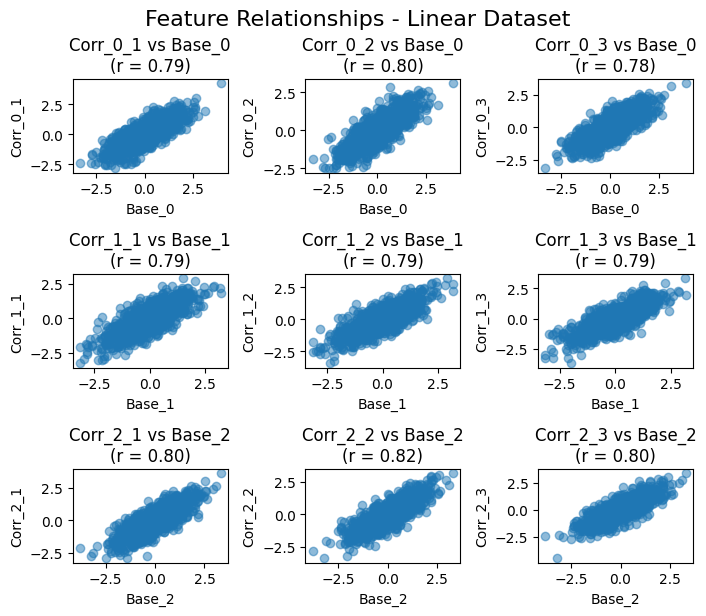

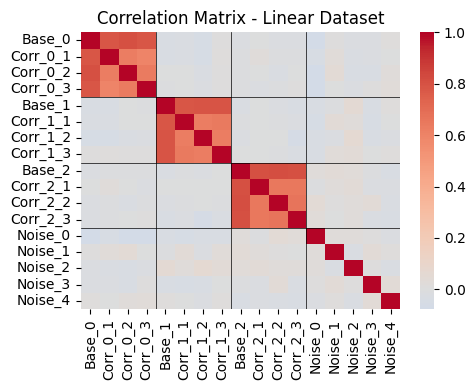

In [ ]:
# Analyze and visualize feature relationships
analyze_dataset(X_linear, cluster_linear)

### Generating and Visualizing a Non-Linear Dataset

Now let's generate a dataset with non-linear relationships between features and visualize them.


In [ ]:
# Generate non-linearly related dataset
X_nonlinear, y_nonlinear, cluster_nonlinear, importance_nonlinear, relationships = generate_nonlinear_dataset(
    nonlinear_strength=0.8,  # Strength of non-linear relationships
    **params
)


Generating non-linearly related dataset with:
- 1000 samples
- 3 clusters with 4 features each
- 5 noise features
- Non-linear relationship strength: 0.8


In [ ]:
# Display dataset information
print("\nDataset Shape:", X_nonlinear.shape)
print("Target Distribution:", y_nonlinear.value_counts().to_dict())


Dataset Shape: (1000, 17)
Target Distribution: {1: 500, 0: 500}


In [ ]:
# Display the relationship types for non-base features
print("\nNon-Linear Relationship Types:")
for feature, relationship in relationships.items():
    if relationship != 'base' and relationship != 'noise':
        print(f"  {feature}: {relationship}")


Non-Linear Relationship Types:
  Nonlin_0_1: mixed
  Nonlin_0_2: mixed
  Nonlin_0_3: mixed
  Nonlin_1_1: exp
  Nonlin_1_2: step
  Nonlin_1_3: piecewise
  Nonlin_2_1: piecewise
  Nonlin_2_2: sine
  Nonlin_2_3: mixed


In [ ]:
# Show first few rows of the dataset
display(X_nonlinear.head())

,Base_0,Nonlin_0_1,Nonlin_0_2,Nonlin_0_3,Base_1,Nonlin_1_1,Nonlin_1_2,Nonlin_1_3,Base_2,Nonlin_2_1,Nonlin_2_2,Nonlin_2_3,Noise_0,Noise_1,Noise_2,Noise_3,Noise_4
0,0.487759,0.244094,-0.322176,0.406829,0.191720,-0.803371,1.345429,0.591276,1.418439,1.482990,0.503470,1.654975,-1.152728,-1.746410,0.348120,0.186010,0.485329
1,-0.161022,-0.620603,-0.675979,-0.512360,-0.472309,-0.681694,-0.829763,-0.007522,-1.294916,-1.270339,-0.555871,-0.132213,0.528813,0.172628,-1.687673,-0.053253,-0.704854
2,0.642015,1.095436,-0.572957,0.121072,-0.140156,0.827722,-1.378555,0.231404,1.141036,0.909326,0.427822,0.629080,-0.064680,0.502639,0.447453,-1.474599,0.195303
3,1.536382,1.515756,0.018748,0.900350,-0.421872,-0.303599,-1.133627,0.232263,-0.037797,0.024999,-0.694361,-0.671758,0.889994,-1.357763,-1.155930,-0.403387,-0.715282
4,-0.258995,-1.545432,-0.842639,-0.675230,-1.174613,-1.563961,-0.594470,-0.985407,-0.079701,-0.279151,0.201410,0.298264,1.156454,-0.086028,-0.039548,-0.532072,-0.296028


Analyzing Non-Linear Dataset Relationships


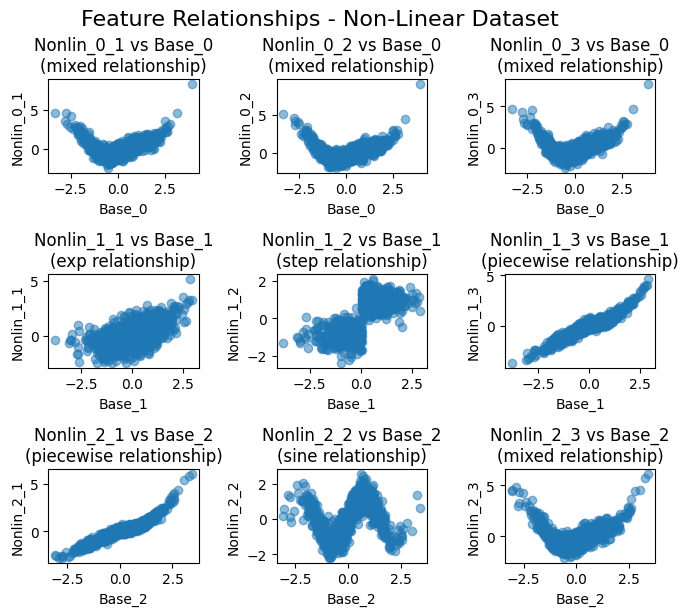

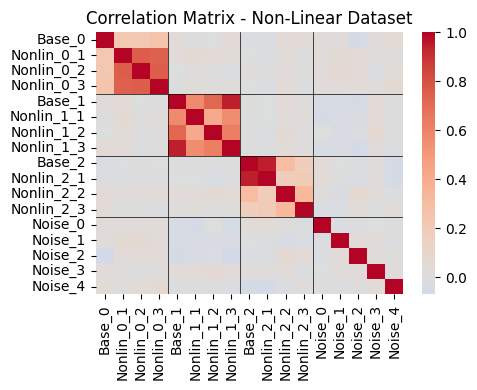

In [ ]:
# Analyze and visualize feature relationships
analyze_dataset(X_nonlinear, cluster_nonlinear, relationships)

In [ ]:
# Display a summary table of the datasets generated
summary_df = pd.DataFrame({
    'Dataset': ['Linear', 'Non-Linear'],
    'Samples': [X_linear.shape[0], X_nonlinear.shape[0]],
    'Features': [X_linear.shape[1], X_nonlinear.shape[1]],
    'Feature Clusters': [len([c for c in set(cluster_linear.values()) if c != "Noise"]),
                        len([c for c in set(cluster_nonlinear.values()) if c != "Noise"])],
    'Noise Features': [len([f for f, c in cluster_linear.items() if c == "Noise"]),
                      len([f for f, c in cluster_nonlinear.items() if c == "Noise"])],
    'Relationship Type': ['Linear Correlation', 'Various Non-Linear']
})

display(summary_df)

,Dataset,Samples,Features,Feature Clusters,Noise Features,Relationship Type
0,Linear,1000,17,3,5,Linear Correlation
1,Non-Linear,1000,17,3,5,Various Non-Linear



# Feature Importance Analysis on Correlated Features

### Training and Evaluation a Random Forest Classifier

---
<font color=green>Q1:</font>
<br><font color='green'>
Begin by selecting which dataset you want to use for your analysis and assigning it to X and y variables. Then write code to split your data into training and test sets with 30% of the data reserved for testing. Use a random_state of 42 for reproducibility.
</font>  

---

In [ ]:
# Select which dataset to use
dataset_choice = "linear" # or "nonlinear"

if dataset_choice == "linear":
  X, y = X_linear, y_linear
else:
  X, y = X_nonlinear, y_nonlinear

In [ ]:
# Split data for model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (700, 17)
Test set shape: (300, 17)


---
<font color=green>Q2:</font>
<br><font color='green'>
Now that you have your training and testing data prepared, create and train a Random Forest classifier with 50 trees (n_estimators). Use a random_state of 42 for reproducibility. Fit the model to your training data (X_train and y_train).
</font>

---

In [ ]:
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

print("Model trained successfully!")

Training Random Forest model...
Model trained successfully!


---
<font color=green>Q3:</font>
<br><font color='green'>
After training your model, it's time to evaluate its performance. Write code to:
1. Generate predictions for the test set
2. Generate probability predictions for the test set (you'll need these for ROC AUC calculation)
3. Calculate accuracy and ROC AUC score for the model
4. Print the results with appropriate formatting
</font>  

---

In [ ]:
# Evaluate performance
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Model performance on test data:")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- ROC AUC: {auc:.4f}")

Model performance on test data:
- Accuracy: 0.8467
- ROC AUC: 0.9305


### Performing Feature-Level Importance Analysis

---
<font color=green>Q4:</font> <br><font color='green'>
Let's perform a more detailed feature importance analysis. First, extract and visualize the Mean Decrease in Impurity (MDI) feature importance from our Random Forest model for all features. Implement the code to calculate and plot these importance values in a horizontal bar chart.
</font>

---

Calculating MDI feature importance...


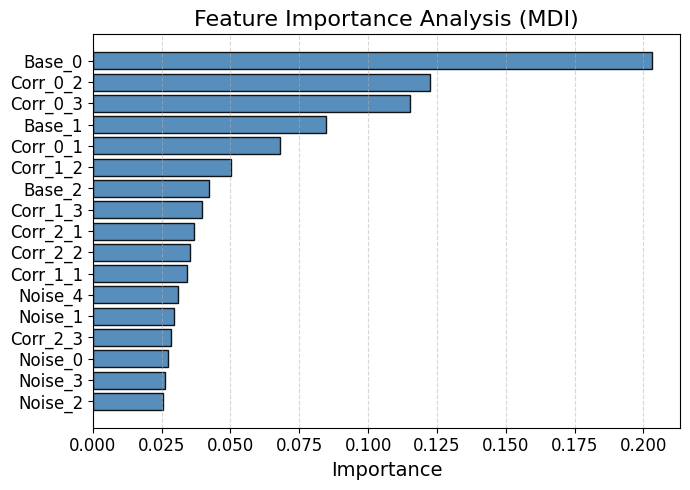

In [ ]:
# Calculate MDI feature importance
print("Calculating MDI feature importance...")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot all features
plt.figure(figsize=(7, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'],
        color='steelblue', edgecolor='black', alpha=0.9)

# Style adjustments
plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Feature Importance Analysis (MDI)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
<font color=green>Q5:</font> <br><font color='green'>
Now, let's compute a different type of feature importance: Permutation Feature Importance (PFI). This method works by randomly shuffling each feature and measuring the decrease in model performance. It can often provide more reliable importance values than MDI, especially for correlated features.
Implement the code to:
1. Calculate permutation importance using the trained Random Forest model
2. Create a DataFrame with the results
3. Visualize the importance values with error bars for all features
</font>

---

Calculating Permutation Feature Importance...


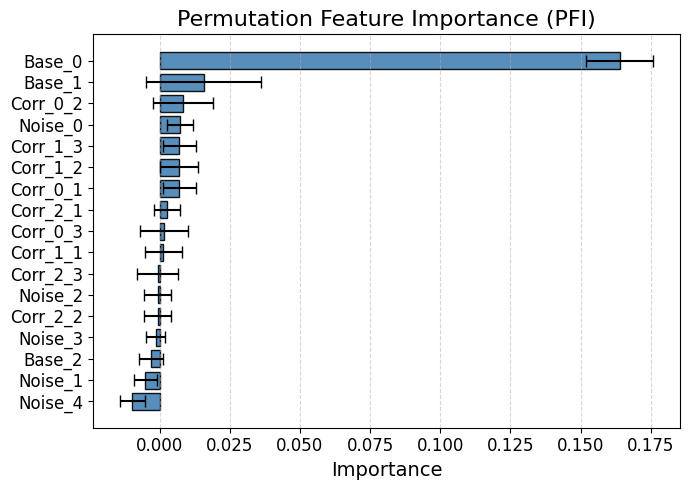

In [ ]:
# Calculate permutation feature importance
print("Calculating Permutation Feature Importance...")
perm_importance = permutation_importance(rf_model, X_test, y_test,
                                        n_repeats=10, random_state=42)

pfi_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

# Plot all features with error bars
plt.figure(figsize=(7, 5))  # Increased height to accommodate all features
bars = plt.barh(pfi_importance['Feature'], pfi_importance['Importance'],
                xerr=pfi_importance['Std'],
                color='steelblue', edgecolor='black',
                capsize=4, alpha=0.9)

# Style adjustments
plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Permutation Feature Importance (PFI)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Cluster-level Feature Importance Analysis

### Creating the distance matrix

---
<font color=green>Q6:</font> <br><font color='green'>
Now let's move to analyzing feature clusters. The first step is to create a distance matrix from our feature matrix. We'll use Spearman correlation since it can capture monotonic relationships (not just linear ones). Implement a function to compute a distance matrix where the distance between features is defined as 1 minus the absolute value of their Spearman correlation coefficient.
</font>

---

In [ ]:
def compute_spearman_distance_matrix(X):
    """
    Computes a distance matrix (1 - |Spearman correlation|) for the input DataFrame or array.

    Parameters:
    -----------
    X : pandas.DataFrame or np.ndarray
        Input data where rows are samples and columns are features.

    Returns:
    --------
    pd.DataFrame
        Distance matrix with feature names as both row and column labels.
    """
    # Compute Spearman correlation
    corr = spearmanr(X).correlation

    # Ensure symmetry and correct diagonal
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # Compute distance matrix
    distance_matrix = 1 - np.abs(corr)

    # Assign feature names
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]

    return pd.DataFrame(distance_matrix, index=feature_names, columns=feature_names)

In [ ]:
# Compute the distance matrix
distance_matrix = compute_spearman_distance_matrix(X)

print(f"Distance matrix shape: {distance_matrix.shape}")

Distance matrix shape: (17, 17)


---
<font color=green>Q7:</font> <br><font color='green'>
Let's visualize both the correlation matrix and the distance matrix side by side to understand the relationship between them. The correlation matrix shows how strongly features are related (higher values indicate stronger relationships), while the distance matrix shows how far apart features are in terms of their behavior (higher values indicate less related features).
</font>

---

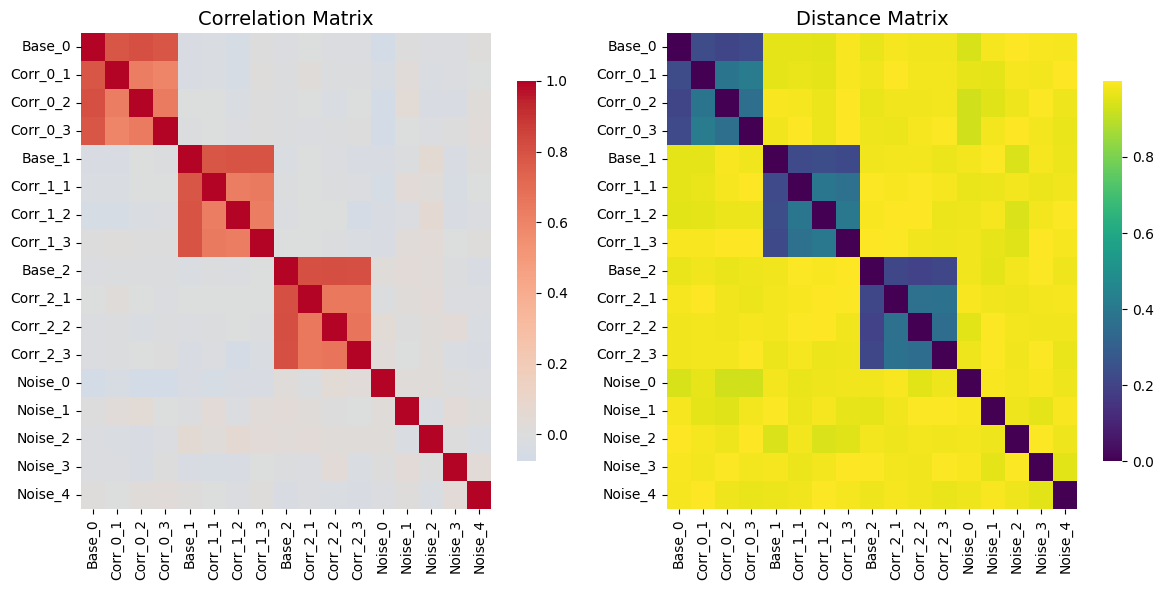

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot correlation matrix
sns.heatmap(X.corr(), cmap='coolwarm', center=0, ax=axes[0],
            cbar_kws={"shrink": .8})
axes[0].set_title('Correlation Matrix', fontsize=14)

# Plot distance matrix
sns.heatmap(distance_matrix, cmap='viridis', ax=axes[1],
            cbar_kws={"shrink": .8})
axes[1].set_title('Distance Matrix', fontsize=14)

plt.tight_layout()
plt.show()


### Clustering the distance matrix

> Ajouter une citation



---
<font color=green>Q8:</font> <br><font color='green'>
Now that we have created a distance matrix representing the relationships between features, let's cluster the features to identify groups of related variables. We'll first implement an `OptimalClusterer` class that combines dimensionality reduction with clustering techniques. Your task is to understand the purpose of each method in this class and how they work together to find optimal feature clusters.
</font>

---

In [ ]:
class OptimalClusterer:
    """
    A class that combines dimensionality reduction with clustering techniques to find
    optimal feature clusters based on a distance matrix.

    The workflow is:
    1. Apply PCA to reduce dimensionality of the distance matrix while preserving variance
    2. Find the optimal number of clusters using cluster quality metrics
    3. Apply K-means clustering to get initial cluster assignments
    4. Refine with Gaussian Mixture Model to get probabilistic cluster memberships

    Parameters:
    -----------
    variance_threshold : float, default=0.95
        The minimum explained variance to determine number of PCA components
    max_clusters : int, default=10
        The maximum number of clusters to consider when determining optimal k
    random_state : int, default=42
        Random seed for reproducibility
    """
    def __init__(self, variance_threshold=0.95, max_clusters=10, random_state=42):
        self.variance_threshold = variance_threshold
        self.max_clusters = max_clusters
        self.random_state = random_state
        self.features = None
        self.pca_data = None
        self.optimal_k = None
        self.kmeans = None

    def apply_pca(self, dist_matrix):
        """
        Apply PCA to the distance matrix and determine the optimal number of components.

        This method:
        1. Stores the feature names for later use
        2. Fits a PCA model to the distance matrix
        3. Determines how many components are needed to reach the variance threshold
        4. Stores the reduced data with optimal number of components
        5. Plots the cumulative explained variance

        Parameters:
        -----------
        dist_matrix : pandas.DataFrame
            The distance matrix between features

        Returns:
        --------
        None
        """
        ## YOUR CODE HERE ##

        pass

    def find_optimal_clusters(self, method='silhouette'):
        """
        Find the optimal number of clusters using a specified cluster quality metric.

        This method:
        1. Tests different numbers of clusters (from 2 to max_clusters)
        2. For each K value, fits a K-means model and calculates the quality score
        3. Determines the optimal K that maximizes the quality score

        Available metrics:
        - 'silhouette': Measures how similar a point is to its own cluster compared to others
        - 'calinski': Ratio of between-cluster to within-cluster dispersion
        - 'davies': Average similarity of clusters (lower is better, so score is negated)

        Parameters:
        -----------
        method : str, default='silhouette'
            The cluster quality metric to use

        Returns:
        --------
        int
            The optimal number of clusters
        """
        ## YOUR CODE HERE ##
        pass

    def apply_kmeans(self):
        """
        Apply K-means clustering using the optimal number of clusters.

        This method:
        1. Fits a K-means model with the optimal K
        2. Creates a dictionary mapping cluster labels to feature names

        Returns:
        --------
        dict
            Dictionary where keys are cluster labels and values are lists of feature names
        """
        ## YOUR CODE HERE ##
        pass

    def apply_gmm(self, reg_covar=1e-3):
        """
        Apply Gaussian Mixture Model for soft clustering.

        This method:
        1. Initializes GMM with K-means cluster centers for better convergence
        2. Fits the GMM to the PCA-reduced data
        3. Gets the probability of each feature belonging to each cluster

        Parameters:
        -----------
        reg_covar : float, default=1e-3
            Regularization parameter for covariance matrices

        Returns:
        --------
        pandas.DataFrame
            DataFrame containing the probability of each feature (rows)
            belonging to each cluster (columns)
        """
        ## YOUR CODE HERE ##
        pass

---
<font color=green>Q9:</font> <br><font color='green'>
Now let's apply our clustering workflow to the distance matrix we created. First, we'll use PCA to reduce the dimensionality while preserving most of the variance. This step is important because clustering algorithms often perform better in lower-dimensional spaces, especially with high-dimensional distance matrices.
</font>

---

Applying PCA to the distance matrix...


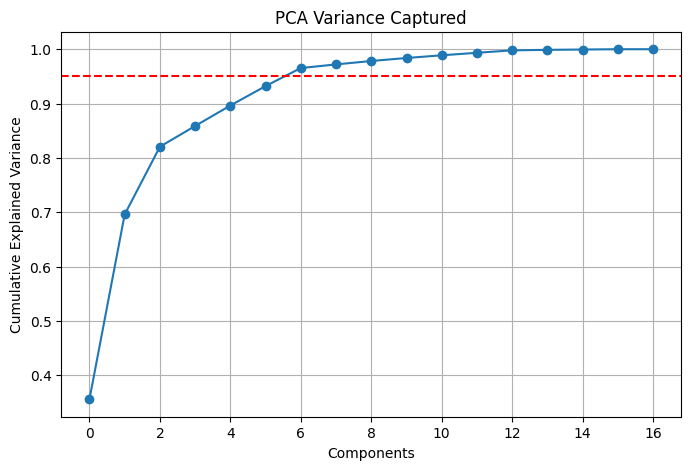

Original dimensions: (17, 17)
Reduced dimensions after PCA: (17, 7)
Dimensions reduced from 17 to 7 while preserving 95% variance


In [ ]:
# Initialize the clusterer
## YOUR CODE HERE ##

# Apply PCA and plot the captured variance
print("Applying PCA to the distance matrix...")
## YOUR CODE HERE ##

print(f"Original dimensions: {distance_matrix.shape}")
print(f"Reduced dimensions after PCA: {clusterer.pca_data.shape}")
print(f"Dimensions reduced from {distance_matrix.shape[1]} to {clusterer.pca_data.shape[1]} while preserving 95% variance")


---
<font color=green>Q10:</font> <br><font color='green'>
Next, we need to determine the optimal number of clusters for our data. We'll use clustering quality metrics such as the silhouette score, which measures how well-separated the clusters are. Implement the code to find the optimal number of clusters and visualize the scores for different values of K.
</font>

---


Finding optimal number of clusters...
Optimal number of clusters: 4


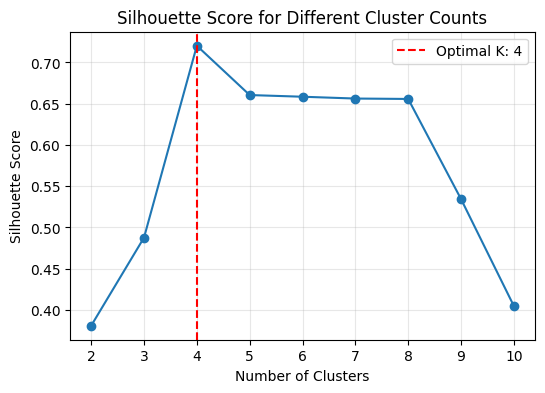

In [ ]:
# Find optimal clusters using silhouette method
print("\nFinding optimal number of clusters...")
## YOUR CODE HERE ##
print(f'Optimal number of clusters: {optimal_clusters}')

# Let's also visualize the scores for different cluster counts
## YOUR CODE HERE ##

---
<font color=green>Q11:</font> <br><font color='green'>
Now that we've determined the optimal number of clusters, let's apply K-means clustering to get our initial cluster assignments.
</font>

---

In [ ]:
# Apply K-means clustering
## YOUR CODE HERE ##

# Print summary of each cluster
## YOUR CODE HERE ##



Applying K-means clustering...

Cluster 0 has 4 features:
  Sample features: Base_1, Corr_1_1, Corr_1_2, Corr_1_3

Cluster 1 has 4 features:
  Sample features: Base_2, Corr_2_1, Corr_2_2, Corr_2_3

Cluster 2 has 4 features:
  Sample features: Base_0, Corr_0_1, Corr_0_2, Corr_0_3

Cluster 3 has 5 features:
  Sample features: Noise_0, Noise_1, Noise_2, Noise_3, Noise_4


---
<font color=green>Q12:</font> <br><font color='green'>
Finally, let's apply a Gaussian Mixture Model (GMM) to get probabilistic cluster assignments.
</font>

---

In [ ]:
# Apply Gaussian Mixture Model
print("\nApplying Gaussian Mixture Model for soft clustering...")
## YOUR CODE HERE ##


Applying Gaussian Mixture Model for soft clustering...


In [ ]:
# Display the first few rows
print('\nGMM Probabilities (first 5 features):')
## YOUR CODE HERE ##


GMM Probabilities (first 5 features):
             Cluster_0     Cluster_1     Cluster_2     Cluster_3
Base_0    6.140503e-11  2.075025e-11  9.999999e-01  1.223652e-07
Corr_0_1  1.071303e-09  3.021370e-10  9.999979e-01  2.108155e-06
Corr_0_2  3.172138e-10  2.143398e-10  9.999986e-01  1.441955e-06
Corr_0_3  4.635441e-10  2.744858e-10  9.999981e-01  1.939794e-06
Base_1    9.999999e-01  2.650198e-11  5.107657e-11  1.398806e-07


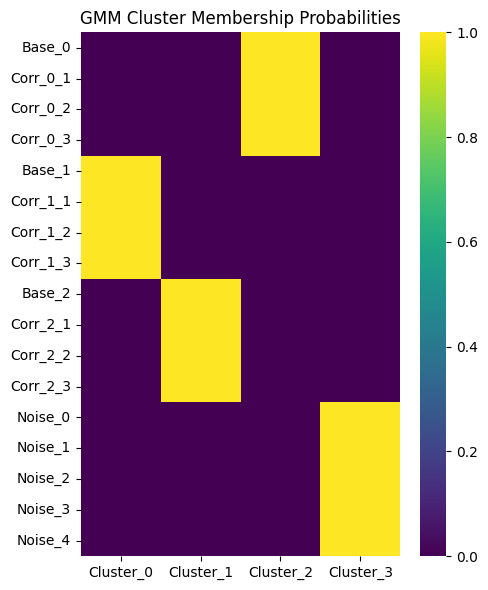

In [ ]:
# Plot heatmap of GMM probabilities
## YOUR CODE HERE ##

### Cluster level feature importance Analysis

---
<font color=green>Q13:</font> <br><font color='green'>
Now that we have identified our feature clusters, let's perform feature importance analysis at the cluster level. This approach helps us understand which groups of related features are most influential for our model's predictions. First, implement a function to calculate Mean Decrease Impurity (MDI) importance aggregated at the cluster level.
</font>

---

In [ ]:
def calculate_cluster_importance_mdi(model, feature_names, clusters):
    """
    Calculate Mean Decrease Impurity (MDI) feature importance at the cluster level.

    Parameters:
    -----------
    model : fitted sklearn ensemble model
        Model with estimators_ attribute
    feature_names : list
        List of feature names
    clusters : dict
        Dictionary mapping cluster IDs to lists of feature names

    Returns:
    --------
    cluster_importance : pandas DataFrame
        DataFrame with mean and std of cluster importance
    """
    # Extract feature importance from all trees
    if hasattr(model, 'estimators_'):
        importances = {i: tree.feature_importances_
                      for i, tree in enumerate(model.estimators_)}
    else:
        importances = {0: model.feature_importances_}

    # Convert to DataFrame
    imp_df = pd.DataFrame.from_dict(importances, orient='index')
    imp_df.columns = feature_names

    # Replace zeros with NaN (happens when max_features=1)
    imp_df = imp_df.replace(0, np.nan)

    # Group by clusters
    cluster_importance = pd.DataFrame(columns=['mean', 'std'])

    for cluster_id, features in clusters.items():
        # Filter to include only features that exist in the model
        valid_features = [f for f in features if f in feature_names]

        if valid_features:
            # Sum importances across features in cluster for each tree
            cluster_imp = imp_df[valid_features].sum(axis=1)

            # Calculate mean and std of cluster importance
            cluster_importance.loc[f'Cluster_{cluster_id}', 'mean'] = cluster_imp.mean()
            if len(cluster_imp) > 1:
                cluster_importance.loc[f'Cluster_{cluster_id}', 'std'] = (
                    cluster_imp.std() * cluster_imp.shape[0]**-0.5
                )
            else:
                cluster_importance.loc[f'Cluster_{cluster_id}', 'std'] = 0

    # Normalize to sum to 1
    total_importance = cluster_importance['mean'].sum()
    if total_importance > 0:
        cluster_importance['mean'] = cluster_importance['mean'] / total_importance

    return cluster_importance

---
<font color=green>Q14:</font> <br><font color='green'>
Now, let's implement another approach to calculate cluster importance: Permutation Feature Importance (PFI). This method works by permuting all features within a cluster together and measuring the drop in model performance.
</font>

---

In [ ]:
def calculate_cluster_importance_pfi(model, X, y, clusters, cv=5, scoring='neg_log_loss'):
    """
    Calculate Mean performance feature importance (PFI) at the cluster level.

    Parameters:
    -----------
    model : sklearn estimator
        Model with fit and predict_proba methods
    X : pandas DataFrame
        Feature matrix
    y : pandas Series or array-like
        Target variable
    clusters : dict
        Dictionary mapping cluster IDs to lists of feature names
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_log_loss'
        Scoring metric for evaluating importance

    Returns:
    --------
    cluster_importance : pandas DataFrame
        DataFrame with mean and std of cluster importance
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import log_loss

    # Set up cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Initialize results DataFrames
    baseline_scores = pd.Series(dtype='float64')  # baseline scores
    permutation_scores = pd.DataFrame(columns=clusters.keys())  # scores after permutation

    # Perform cross-validation
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Get baseline predictions and score
        y_pred = model.predict_proba(X_test)
        baseline_scores.loc[i] = -log_loss(y_test, y_pred, labels=model.classes_)

        # For each cluster, shuffle all its features and compute score
        for cluster_id in clusters.keys():
            # Create a copy of the test set
            X_test_permuted = X_test.copy()

            # Get cluster features that exist in the dataset
            cluster_features = [f for f in clusters[cluster_id] if f in X.columns]

            if cluster_features:  # Only process if there are valid features
                # Shuffle all features in the cluster with the same permutation
                # This preserves correlations within cluster
                permutation_idx = np.random.permutation(len(X_test))
                for feature in cluster_features:
                    X_test_permuted[feature] = X_test_permuted[feature].values[permutation_idx]

                # Get predictions on permuted data
                y_pred_permuted = model.predict_proba(X_test_permuted)

                # Calculate score
                permutation_scores.loc[i, cluster_id] = -log_loss(
                    y_test, y_pred_permuted, labels=model.classes_
                )

    # Calculate importance as normalized performance drop
    importance = (-1 * permutation_scores).add(baseline_scores, axis=0)
    importance = importance / (-1 * permutation_scores)

    # Calculate mean and std
    cluster_importance = pd.DataFrame({
        'mean': importance.mean(),
        'std': importance.std() * importance.shape[0]**-0.5
    })

    # Rename index for clarity
    cluster_importance.index = [f'Cluster_{i}' for i in cluster_importance.index]

    return cluster_importance

---
<font color=green>Q15:</font> <br><font color='green'>
Finally, let's apply both cluster importance methods to our model and compare the results. This will help us understand which clusters of features are most important for prediction, accounting for the correlations between features within each cluster.
</font>

---

In [ ]:
# Calculate cluster-level importance using MDI
print("Calculating cluster-level MDI importance...")
## YOUR CODE HERE ##

Calculating cluster-level MDI importance...


In [ ]:
# Calculate cluster-level importance using PFI
print("Calculating cluster-level PFI importance...")
## YOUR CODE HERE ##

Calculating cluster-level PFI importance...


<Figure size 1000x800 with 0 Axes>

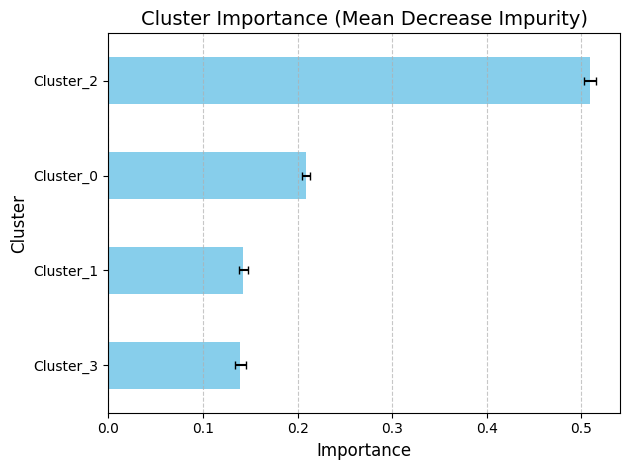

In [ ]:
# Plot MDI cluster importance
plt.figure(figsize=(10, 8))
cluster_imp_mdi.sort_values('mean').plot(
    kind='barh',
    y='mean',
    xerr='std',
    legend=False,
    color='skyblue',
    capsize=3
)
plt.title('Cluster Importance (Mean Decrease Impurity)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

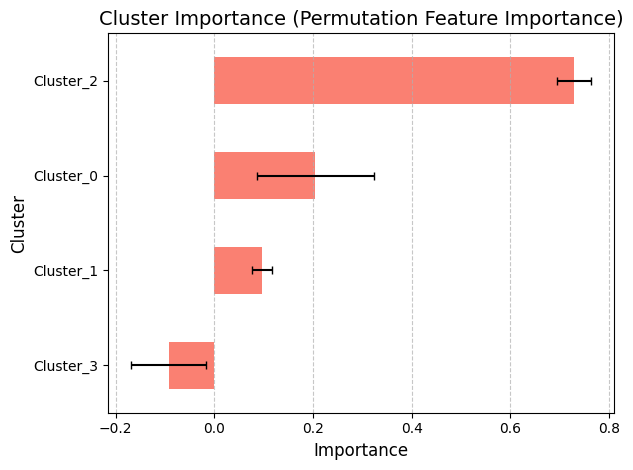

In [ ]:
# Plot PFI on a cluster level
plt.figure(figsize=(10, 8))
cluster_imp_pfi.sort_values('mean').plot(
    kind='barh',
    y='mean',
    xerr='std',
    legend=False,
    color='salmon',
    capsize=3
)
plt.title('Cluster Importance (Permutation Feature Importance)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

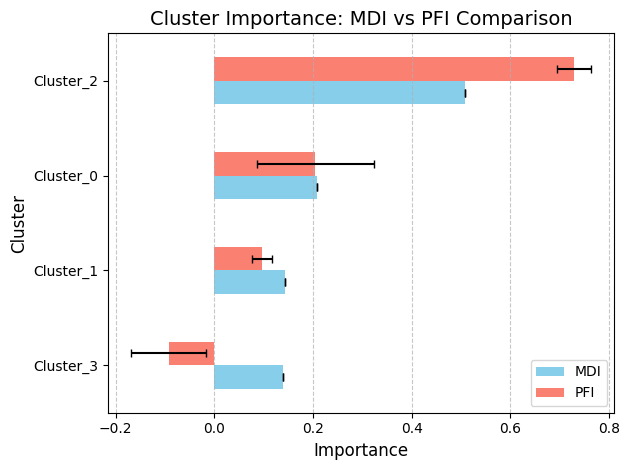

In [ ]:
# Compare MDI and PFI importance
plt.figure(figsize=(12, 8))

# Prepare data for comparison
comparison_clusters = list(set(cluster_imp_mdi.index) & set(cluster_imp_pfi.index))
comparison_df = pd.DataFrame(index=comparison_clusters)
comparison_df['MDI'] = [cluster_imp_mdi.loc[cluster, 'mean'] for cluster in comparison_clusters]
comparison_df['PFI'] = [cluster_imp_pfi.loc[cluster, 'mean'] for cluster in comparison_clusters]

# Sort by MDI importance
comparison_df = comparison_df.sort_values('PFI', ascending=True)

# Plot comparison
comparison_df.plot(
    kind='barh',
    color=['skyblue', 'salmon'],
    xerr=[
        [0] * len(comparison_df),  # No error bars for first series
        [cluster_imp_pfi.loc[cluster, 'std'] for cluster in comparison_df.index]
    ],
    capsize=3
)

plt.title('Cluster Importance: MDI vs PFI Comparison', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"cluster_importance_comparison_{dataset_choice}.png", dpi=300, bbox_inches='tight')
plt.show()